In [398]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [399]:
import json
import os, sys
import pandas as pd
import numpy as np

# Cell Number per population from BBP S1 model

In [400]:
Epops= ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

with open('anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

popParamLabels = []
Ipops = []

for line in mtype_content.split('\n')[:-1]:
    metype, mtype, etype, n, m = line.split()
    if mtype not in popParamLabels:
        popParamLabels.append(mtype)
        if mtype not in Epops:
            Ipops.append(mtype)
n2 = 0
metag = {}
popNumber2 = {}
cellNumber = {} 
popLabel = {} 
popLabelEl = {} 
meParamLabels = {} 
for line in mtype_content.split('\n')[:-1]:
    metype, mtype, etype, n, m = line.split()
    cellNumber[metype] = int(n)
    popLabel[metype] = mtype
    popLabelEl[metype] = etype
    popNumber2[mtype] = int(m)
    metag[metype] = n2    
    n2 = n2 + 1

with open('anatomy/mtype_map.tsv') as mtype_map_file:
    mtype_map_content = mtype_map_file.read()    
mtype_map = {}
mtype_map2 = {}
for line in mtype_map_content.split('\n')[:-1]:
    n, mtype = line.split()
    mtype_map[mtype] = int(n)
    mtype_map2[int(n)] = mtype    

# Anatomy pathways from Netconnections_mean.json (Cell2015)

In [401]:
# initialize prob and weight matrices
# format: pmat[presynaptic_pop][postsynaptic_pop] 
data = {}
data['BBP_S1'] = {}
with open('anatomy/Netconnections_mean.json', 'r') as f:
    data['BBP_S1']['connProb'] = json.load(f) 
connDataSource = {}
connDataSource['E->E/I'] = 'BBP_S1' 
connDataSource['I->E/I'] = 'BBP_S1' 
pmat = {}  # probability of connection matrix full mc2
connNumber = {}        # ~ "total_conn_count"
lmat = {}  # length constant (lambda) for exp decaying prob conn (um) matrix
a0mat = {} # probability of connection matrix dist 2D  = 0 um
d0 = {} #  matrix min to fit exp dist 2D [12.5,25,...,150]
dfinal = {} #  matrix max to fit exp dist 2D [125,...,375]
pmat12um = {} # probability of connection matrix dist 2D -> 12.5um +- 12.5um
pmat25um = {} # probability of connection matrix dist 2D -> 25um +- 25um
pmat50um = {}
pmat75um = {}
pmat100um = {}
pmat125um = {}
pmat150um = {}
pmat175um = {}
pmat200um = {}
pmat225um = {}
pmat250um = {}
pmat275um = {}
pmat300um = {}
pmat325um = {}
pmat350um = {}
pmat375um = {} 

lmat_exp = {} # single exp fit
a0mat_exp = {}
d0_exp = {} 

lmat_gauss = {}  # length constant (lambda) for gaussian decaying prob conn (um) matrix
a0mat_gauss = {} # probability in 0 um gaussian decay
x0_gauss = {} # constant x0 in the gaussian decay
d0_gauss = {} # 

best_fit = {} # 'expl' (153), 'exp' (485), 'gauss' (1303)


for p in Epops + Ipops:
    pmat[p] = {}
    connNumber[p] = {}  
    lmat[p] = {}
    a0mat[p] = {}  
    d0[p] = {}
    dfinal[p] = {}
    pmat12um[p] = {}
    pmat25um[p] = {}
    pmat50um[p] = {}
    pmat75um[p] = {}
    pmat100um[p] = {}
    pmat125um[p] = {}
    pmat150um[p] = {}
    pmat175um[p] = {}
    pmat200um[p] = {}
    pmat225um[p] = {}
    pmat250um[p] = {}
    pmat275um[p] = {}
    pmat300um[p] = {}
    pmat325um[p] = {}
    pmat350um[p] = {}
    pmat375um[p] = {}     
    
    lmat_exp[p] = {}
    a0mat_exp[p] = {}  
    d0_exp[p] = {}
    
    lmat_gauss[p] = {}
    a0mat_gauss[p] = {}
    x0_gauss[p] = {}
    d0_gauss[p] = {}
    best_fit[p] = {} #

In [402]:
synperconnNumber = {}        # ~ "mean_number_of_synapse_per_connection"
synperconnNumberStd = {}   
for p in Epops + Ipops:   
    synperconnNumber[p] = {}
    synperconnNumberStd[p] = {}

for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:
            synperconnNumber[pre][post] = 0
            synperconnNumberStd[pre][post] = 0

In [403]:
# LOAD DATA FROM .TSV files resume
with open('anatomy/synNumberperconex.dat') as synNumber_file:
    synNumber_content = synNumber_file.read()
    
for line in synNumber_content.split('\n')[:-1]:
    n, m, mean, stdev, synNumber, proj = line.split()
    pre = mtype_map2[int(n)]
    post = mtype_map2[int(m)]   
    proj = '%s:%s' % (pre, post)
    if proj in data['BBP_S1']['connProb']:    
        synperconnNumber[pre][post] = np.ceil(float(mean))
        synperconnNumberStd[pre][post] = float(stdev)

In [404]:
# LOAD WITH PANDAS DATA FROM json files 
anatomy_data = json.loads(open("anatomy/pathways_anatomy_factsheets_simplified.json").read())
columnNames2 = ["total_synapse_count", "mean_number_of_synapse_per_connection", "number_of_convergent_neuron_mean"]
columnNames = ["From Cell", "To Cell"] + list(anatomy_data[list(anatomy_data.keys() )[0]].keys())
df = pd.DataFrame(columns=columnNames, data = [[k.split(":")[0], k.split(":")[1]] + list(v.values()) for k, v in anatomy_data.items()    ])
df = df.sort_values(by=['From Cell'])
df = df.drop(columns=['number_of_convergent_neuron_std', 'connection_probability', 'number_of_divergent_neuron_std', 'total_synapse_count',
 'common_neighbor_bias', 'number_of_convergent_neuron_mean', 'number_of_divergent_neuron_mean'])
for conn in range(1932):
    pre = df["From Cell"][conn]
    post = df["To Cell"][conn]
    proj = '%s:%s' % (pre, post)
    if proj in data['BBP_S1']['connProb']:
        synperconnNumber[pre][post] = np.ceil(df["mean_number_of_synapse_per_connection"][conn])
        synperconnNumberStd[pre][post] = df["number_of_synapse_per_connection_std"][conn]
df.head()

,From Cell,To Cell,mean_number_of_synapse_per_connection,number_of_synapse_per_connection_std
1616,L1_DAC,L1_SLAC,12.0,3.9
839,L1_DAC,L1_HAC,15.0,6.3
558,L1_DAC,L23_NGC,7.0,1.9
1768,L1_DAC,L4_SP,5.7,1.7
1769,L1_DAC,L4_SS,6.1,2.7


In [405]:
# For missing data use mean of Layer-Type:Layer-Type projections
layersT = ['L1e', 'L2e', 'L4e', 'L5e', 'L6e', 'L1i', 'L2i', 'L4i', 'L5i', 'L6i']
synperconnNumberT = {}
synperconnNumberN = {}
for pre in layersT:
    synperconnNumberT[pre] = {}
    synperconnNumberN[pre] = {}
    for post in layersT:
        synperconnNumberT[pre][post] = 0
        synperconnNumberN[pre][post] = 0           
    
for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:

            if pre in Epops:
                pre2 = str(pre[0:2]) + 'e'
            else:
                pre2 =  str(pre[0:2]) + 'i'
            if post in Epops:
                post2 =  str(post[0:2]) + 'e'
            else:
                post2 =  str(post[0:2]) + 'i'

            if synperconnNumber[pre][post] > 0:
                synperconnNumberT[pre2][post2] = synperconnNumberT[pre2][post2] + synperconnNumber[pre][post]
                synperconnNumberN[pre2][post2] = synperconnNumberN[pre2][post2] + 1

for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:
            if synperconnNumber[pre][post] == 0:
                if pre in Epops:
                    pre2 = str(pre[0:2]) + 'e'
                else:
                    pre2 =  str(pre[0:2]) + 'i'

                if post in Epops:
                    post2 =  str(post[0:2]) + 'e'
                else:
                    post2 =  str(post[0:2]) + 'i'

                synperconnNumber[pre][post] = np.ceil(synperconnNumberT[pre2][post2]/synperconnNumberN[pre2][post2])  #mean of Layer-Type:Layer-Type projections

In [406]:
number = 0 
for pre in Epops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:            
            number = number + synperconnNumber[pre][post] * float(data['BBP_S1']['connProb'][proj]['conn_total'])
print('syn total Exc = %.0f' % number)

syn total Exc = 27614163


In [407]:
numberI = 0 
for pre in Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:            
            numberI = numberI + synperconnNumber[pre][post] * float(data['BBP_S1']['connProb'][proj]['conn_total'])
print('syn total Inh = %.0f' % numberI)

syn total Inh = 10423033


In [408]:
for conn in range(1932): # decrease to compare to Cell2015 - synperconnNumber not avaliable (estimated from .TSV and . JSON files)
    pre = df["From Cell"][conn]
    post = df["To Cell"][conn]
    proj = '%s:%s' % (pre, post)
    if proj in data['BBP_S1']['connProb']:
        if pre in Ipops and synperconnNumber[pre][post]>1.0:
            synperconnNumber[pre][post] = synperconnNumber[pre][post]-1

numberI = 0 
for pre in Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:            
            numberI = numberI + synperconnNumber[pre][post] * float(data['BBP_S1']['connProb'][proj]['conn_total'])
print('syn total Inh = %.0f' % numberI)

syn total Inh = 9684711


In [409]:
number = 0 
for pre in Epops+Ipops:
    for post in Epops+Ipops: 
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:           
            if synperconnNumber[pre][post] > 0:
                number = number + 1
number

1941

# Physiology pathways from Cell2015 (table S6 and portal data)

In [410]:
# LOAD WITH PANDAS DATA FROM json files 
physiology_data = json.loads(open("physiology/pathways_physiology_factsheets_simplified.json").read())
physColumnNames = ["Connection", "From Cell", "From Layer", "From Type", "To Cell", "To Layer", "To Type"] + list(physiology_data[list(physiology_data.keys() )[0]].keys())
df2 = pd.DataFrame(columns=physColumnNames, data = [[k,  k.split(":")[0],  k.split(":")[0].split("_")[0], k.split(":")[0].split("_")[1], k.split(":")[1], k.split(":")[1].split("_")[0], k.split(":")[1].split("_")[1]] + list(v.values()) for k, v in physiology_data.items()    ])
df2 = df2.sort_values(by=['Connection'])
df2.head()

,Connection,From Cell,From Layer,From Type,To Cell,To Layer,To Type,gsyn_mean,epsp_mean,risetime_std,...,space_clamp_correction_factor,latency_std,decay_std,cv_psp_amplitude_std,risetime_mean,cv_psp_amplitude_mean,epsp_std,d_mean,f_mean,failures_std
1558,L1_DAC:L1_DAC,L1_DAC,L1,DAC,L1_DAC,L1,DAC,0.36,2.1,0.85,...,Synaptic conductance not measured experimentally,0.6500,11.0,0.120,5.5,0.49,0.45,750,22.0,7.8
1841,L1_DAC:L1_DLAC,L1_DAC,L1,DAC,L1_DLAC,L1,DLAC,0.41,2.2,0.00,...,Synaptic conductance not measured experimentally,0.0000,0.0,0.000,6.1,0.39,0.00,820,24.0,0.0
1405,L1_DAC:L1_HAC,L1_DAC,L1,DAC,L1_HAC,L1,HAC,0.37,2.4,0.90,...,Synaptic conductance not measured experimentally,0.4700,2.5,0.100,5.8,0.46,0.94,770,22.0,4.6
662,L1_DAC:L1_NGC-DA,L1_DAC,L1,DAC,L1_NGC-DA,L1,NGC-DA,0.26,2.6,0.29,...,Synaptic conductance not measured experimentally,0.0033,1.7,0.026,3.8,0.62,0.52,610,19.0,3.3
513,L1_DAC:L1_NGC-SA,L1_DAC,L1,DAC,L1_NGC-SA,L1,NGC-SA,0.33,2.6,0.58,...,Synaptic conductance not measured experimentally,0.5900,3.3,0.036,4.4,0.58,0.75,710,21.0,1.6


In [411]:
with open('physiology/physiology_synTypes.dat') as physiology_file:
    physiology_content = physiology_file.read()

parameters_name = {}   
ConnTypeNumber = -1  
parameters_syn = {}
syntypes = {}
for line in physiology_content.split('\n')[:-1]:    
    if ConnTypeNumber < 0:
        n2 = 0
        parameters_list = line.split()   
        for parameter in parameters_list:
            parameters_name[n2] = str(parameter)
            n2 = n2 + 1   
    else:
        n2 = 0
        parameters_list = line.split()   
        for parameter in parameters_list:
            if n2 == 0:
                parameters_syn[parameters_name[n2],ConnTypeNumber] = int(parameter)
                syntypes[ConnTypeNumber] = int(parameter)
            elif n2 > 10:
                parameters_syn[parameters_name[n2],ConnTypeNumber] = str(parameter)                
            else:
                parameters_syn[parameters_name[n2],ConnTypeNumber] = float(parameter)
            n2 = n2 + 1
                
    ConnTypeNumber = ConnTypeNumber + 1
    
parameters_name[0]

'ConnType'

In [412]:
physColumnNames = [parameters_name[x] for x in parameters_name]
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.2,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
1,1,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
2,3,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
3,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
4,5,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE
5,8,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
6,9,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
7,10,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
8,11,0.83,0.2,10.4,6.1,0.25,0.13,706.0,405.0,21.0,9.0,I3,IE
9,12,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE


In [413]:
with open('physiology/matrixsyntypes.dat') as synNumber_file:
    synNumber_content = synNumber_file.read()

ConnTypes = {}
ConnTypesNumber = {}      
for p in Epops + Ipops:   
    ConnTypesNumber[p] = {}
    ConnTypes[p] = {}

for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:
            ConnTypesNumber[pre][post] = 0
            ConnTypes[pre][post] = 0
    
for line in synNumber_content.split('\n')[:-1]:
    n, m, number, number2, number3, number4 = line.split()
    pre = mtype_map2[int(n)]
    post = mtype_map2[int(m)]
    proj = '%s:%s' % (pre, post)
    if proj in data['BBP_S1']['connProb']:
        if int(number3)!=50:
            ConnTypesNumber[pre][post] = 3
            ConnTypes[pre][post] = [int(number), int(number2), int(number3)]
        elif int(number2)!=50:
            ConnTypesNumber[pre][post] = 2
            ConnTypes[pre][post] = [int(number), int(number2)]
        elif int(number)!=50:
            ConnTypesNumber[pre][post] = 1
            ConnTypes[pre][post] = [int(number)]

In [414]:
# ConnTypes II
for pre in Ipops:
    for post in Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:                
            if ConnTypesNumber[pre][post] == 0:
#                 print ('ConnNumberTypes[%s][%s] = %d' % (pre, post, ConnTypesNumber[pre][post])) 
                ConnTypesNumber[pre][post] = 1
                ConnTypes[pre][post] = [1]     

In [415]:
# ConnTypes IE
for pre in Ipops: # L1 
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:           
            if str(pre[0:2]) == 'L1':
                ConnTypesNumber[pre][post] = 1
                ConnTypes[pre][post] = [1]    
                
for pre in Ipops:
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if str(pre[-3:]) == 'NGC':
                ConnTypesNumber[pre][post] = 1
                ConnTypes[pre][post] = [11]    
                
ConnTypesNumber['L23_MC']['L6_IPC'] = 1
ConnTypes['L23_MC']['L6_IPC'] = [9]

ConnTypesNumber['L6_DBC']['L6_SBC'] = 1
ConnTypes['L6_DBC']['L6_SBC'] = [0]

for pre in Ipops:
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if str(pre[-3:]) == 'ChC':
                ConnTypesNumber[pre][post] = 1
                ConnTypes[pre][post] = [12]  

for pre in Ipops:
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if str(pre[-3:]) == 'DBC' or str(pre[-3:]) == '_BP' or str(pre[-3:]) == 'BTC':
                ConnTypesNumber[pre][post] = 1
                ConnTypes[pre][post] = [8]  
for pre in Ipops:
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if str(pre[-3:]) == 'SBC':
                ConnTypesNumber[pre][post] = 3
                ConnTypes[pre][post] = [4, 5, 3]   
                
for pre in Ipops:
    for post in Epops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if str(pre[-3:]) == 'LBC' or str(pre[-3:]) == 'NBC':
                ConnTypesNumber[pre][post] = 2
                ConnTypes[pre][post] = [5, 10]

In [416]:
# ConnTypes EI
ConnTypesNumber['L4_SS']['L1_HAC'] = 1
ConnTypes['L4_SS']['L1_HAC'] = [117]
ConnTypesNumber['L5_TTPC1']['L1_HAC'] = 1
ConnTypes['L5_TTPC1']['L1_HAC'] = [117]
ConnTypesNumber['L5_TTPC2']['L1_HAC'] = 1
ConnTypes['L5_TTPC2']['L1_HAC'] = [117]
ConnTypesNumber['L5_UTPC']['L1_DAC'] = 1
ConnTypes['L5_UTPC']['L1_DAC'] = [117]
ConnTypesNumber['L6_TPC_L1']['L23_NGC'] = 1
ConnTypes['L6_TPC_L1']['L23_NGC'] = [117]

In [417]:
for pre in Epops:
    for post in Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if ConnTypesNumber[pre][post] == 2:
                if 117 in ConnTypes[pre][post]:
                    ConnTypes[pre][post] = [117, 114]
                elif 134 in ConnTypes[pre][post]:
                    ConnTypes[pre][post] = [134, 115]          

print(ConnTypes['L4_PC']['L23_BP'],
ConnTypes['L5_STPC']['L23_DBC'],
ConnTypes['L5_UTPC']['L23_DBC'],
ConnTypesNumber['L4_PC']['L23_BP'],
ConnTypesNumber['L5_STPC']['L23_DBC'],
ConnTypesNumber['L5_UTPC']['L23_DBC'])

ConnTypes['L4_PC']['L23_BP'].append(114)
ConnTypes['L5_STPC']['L23_DBC'].append(114)
ConnTypes['L5_UTPC']['L23_DBC'].append(114)
ConnTypesNumber['L4_PC']['L23_BP'] = 2
ConnTypesNumber['L5_STPC']['L23_DBC'] = 2
ConnTypesNumber['L5_UTPC']['L23_DBC'] = 2

print(ConnTypes['L4_PC']['L23_BP'],
ConnTypes['L5_STPC']['L23_DBC'],
ConnTypes['L5_UTPC']['L23_DBC'],
ConnTypesNumber['L4_PC']['L23_BP'],
ConnTypesNumber['L5_STPC']['L23_DBC'],
ConnTypesNumber['L5_UTPC']['L23_DBC'])

[117] [117] [117] 1 1 1
[117, 114] [117, 114] [117, 114] 2 2 2


In [418]:
number = 0
for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:   
            if ConnTypesNumber[pre][post] > 0:
#                 print ('ConnNumberTypes[%s][%s] = %d' % (pre, post, ConnTypesNumber[pre][post])) 
#                 print (ConnTypes[pre][post])
                number = number + 1
number      

1941

In [419]:
# initialize Phys parameters matrix
gsyn = {}         
decay = {}      
use = {}
dep = {}
fac = {}
gsynStd = {}    
decayStd = {}  
useStd = {}
depStd = {}
facStd = {}
stypes = {}
EItype = {} 

for p in Epops + Ipops:
    gsyn[p] = {}          
    decay[p] = {}       
    use[p] = {} 
    dep[p] = {} 
    fac[p] = {}  
    gsynStd[p] = {}     
    decayStd[p] = {}   
    useStd[p] = {} 
    depStd[p] = {} 
    facStd[p] = {} 
    stypes[p] = {} 
    EItype[p] = {} 
    
connType = {}
for conn in range(29):
    connType[parameters_syn['ConnType',conn]] = conn
    
number = 0
for pre in Epops+Ipops:
    for post in Epops+Ipops:
        proj = '%s:%s' % (pre, post)
        if proj in data['BBP_S1']['connProb']:  
            
            conn = connType[ConnTypes[pre][post][0]]
            
            gsyn[pre][post] = parameters_syn['gsyn',conn]
            gsynStd[pre][post] =  parameters_syn['gsynStd',conn]
            decay[pre][post] =  parameters_syn['decay',conn]
            decayStd[pre][post] =parameters_syn['decayStd',conn]
            use[pre][post] = parameters_syn['use',conn]
            useStd[pre][post] = parameters_syn['useStd',conn]
            dep[pre][post] = parameters_syn['dep',conn]
            depStd[pre][post] =parameters_syn['depStd',conn]
            fac[pre][post] = parameters_syn['fac',conn]
            facStd[pre][post] = parameters_syn['facStd',conn]
            stypes[pre][post] = parameters_syn['s-types',conn]
            EItype[pre][post] = parameters_syn['type',conn]
            
            number = number + 1
number           

1941

In [420]:
# if connDataSource['E->E/I'] == 'BBP_S1': 
if connDataSource['I->E/I'] ==  'BBP_S1': 
    for pre in popParamLabels:
        for post in popParamLabels:
            proj = '%s:%s' % (pre, post)
            if proj in data['BBP_S1']['connProb']:
                pmat[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_full']
                connNumber[pre][post] = data['BBP_S1']['connProb'][proj]['conn_total']

                lmat[pre][post] = data['BBP_S1']['connProb'][proj]['shape']
                a0mat[pre][post] = data['BBP_S1']['connProb'][proj]['A0']
                d0[pre][post] = data['BBP_S1']['connProb'][proj]['d_init']
                dfinal[pre][post] = data['BBP_S1']['connProb'][proj]['d_final']

                pmat12um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_12.5um'] 
                pmat25um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_25um'] 
                pmat50um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_50um'] 
                pmat75um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_75um'] 
                pmat100um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_100um']
                pmat125um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_125um']
                pmat150um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_150um']
                pmat175um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_175um']
                pmat200um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_200um']
                pmat225um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_225um']
                pmat250um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_250um']
                pmat275um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_275um']
                pmat300um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_300um']
                pmat325um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_325um']
                pmat350um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_350um']
                pmat375um[pre][post] = data['BBP_S1']['connProb'][proj]['conn_prob_375um']
                
                lmat_exp[pre][post] = data['BBP_S1']['connProb'][proj]['singleexp_shape']
                a0mat_exp[pre][post] = data['BBP_S1']['connProb'][proj]['singleexp_A0']
                d0_exp[pre][post] = data['BBP_S1']['connProb'][proj]['singleexp_d_init']
                
                lmat_gauss[pre][post] = data['BBP_S1']['connProb'][proj]['singlegauss_shapeg']
                a0mat_gauss[pre][post] = data['BBP_S1']['connProb'][proj]['singlegauss_A0g']
                x0_gauss[pre][post] = data['BBP_S1']['connProb'][proj]['singlegauss_x0g']
                d0_gauss[pre][post] = data['BBP_S1']['connProb'][proj]['singlegauss_d_init']    
                
                best_fit[pre][post] = data['BBP_S1']['connProb'][proj]['best_fit']               
                
            else:
                connNumber[pre][post] = 0     

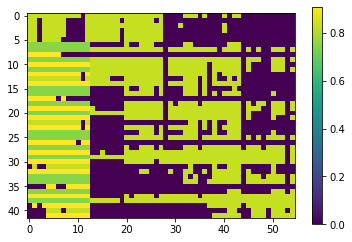

In [421]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
number = 0
matrix = np.zeros((42, 55)) #13 + 42
for pre in Ipops:
    number2 = 0
    for post in Epops+Ipops:
        if float(connNumber[pre][post]) > 0:
            matrix[number][number2] = gsyn[pre][post]      
        else:
            matrix[number][number2] = 0    
        number2 = number2 + 1   
    number = number + 1

# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.imshow(matrix)
plt.colorbar()

In [422]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# Load 55 Morphological Names-> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names-> L1:14 L23:43 L4:46 L5:52 L6:52

rootFolder = '/home/fernando/S1_netpyne'
with open(rootFolder + '/info/anatomy/S1-cells-distributions-Rat.txt') as metype_file:
    metype_content = metype_file.read()       

MtypeNumberRat = {}
NRat = 0
for line in metype_content.split('\n')[:-1]:
    metype, mtype, etype, n, m = line.split()
    MtypeNumberRat[mtype] = int(m)

    NRat = NRat + int(n)
    
print ('Number of cells = %d' % NRat)

Number of cells = 31346


In [423]:
addQuantalSyn = 1 
#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background
#------------------------------------------------------------------------------
if addQuantalSyn:   
    synperNeuronE = {}
    synperNeuronI = {}
    GsynE = {}
    GsynI = {}
    for post in Ipops + Epops:
        synperNeuronE[post] = 0
        synperNeuronI[post] = 0    
        GsynE[post] = 0
        GsynI[post] = 0
    
    for post in Ipops + Epops:
        for pre in Ipops:
            if float(connNumber[pre][post]) > 0:
                synTotal = float(connNumber[pre][post])*synperconnNumber[pre][post]       
                synperNeuron = synTotal/MtypeNumberRat[post]
                synperNeuronI[post] = synperNeuronI[post] + synperNeuron
                GsynI[post] = GsynI[post] + gsyn[pre][post] * synperNeuron

        for pre in Epops:
            if float(connNumber[pre][post]) > 0:
                synTotal = float(connNumber[pre][post])*synperconnNumber[pre][post]       
                synperNeuron = synTotal/MtypeNumberRat[post]
                synperNeuronE[post] = synperNeuronE[post] + synperNeuron
                GsynE[post] = GsynE[post] + gsyn[pre][post] * synperNeuron

    GsynTotalE = 0
    GsynTotalI = 0
    synTotalE = 0
    synTotalI = 0
    for post in Ipops + Epops:
        for pre in Ipops:
            if float(connNumber[pre][post]) > 0:
                synTotal = float(connNumber[pre][post])*synperconnNumber[pre][post] 
                GsynTotalI = GsynTotalI + gsyn[pre][post] * synTotal                
                synTotalI = synTotalI + synTotal                
        for pre in Epops:
            if float(connNumber[pre][post]) > 0:
                synTotal = float(connNumber[pre][post])*synperconnNumber[pre][post]      
                GsynTotalE = GsynTotalE + gsyn[pre][post] * synTotal              
                synTotalE = synTotalE + synTotal
         
print ('G_Exc = %.2f nS (%.d), G_Inh = %.2f nS (%.d)' % (GsynTotalE/NRat, synTotalE/NRat, GsynTotalI/NRat, synTotalI/NRat))                
print ('mean G_Exc = %.2f nS, mean G_Inh = %.2f nS ' % (GsynTotalE/synTotalE, GsynTotalI/synTotalI))

G_Exc = 693.32 nS (880), G_Inh = 257.91 nS (308)
mean G_Exc = 0.79 nS, mean G_Inh = 0.83 nS 


In [424]:
# If do not use np.ceil() and decrease by 1 the synperconnNumber Inh
# G_Exc = 622.97 nS (789), G_Inh = 275.95 nS (330)
# mean G_Exc = 0.79 nS, mean G_Inh = 0.83 nS 

# Cell 2015
# The predicted average total synaptic conductance for single neurons was 1000 nS (750 nS excitatory and
# 250 nS inhibitory conductance; based on all synapses in BioM). Predicted average quantal conductance was 
# 0.85 ± 0.44 nS for excitatory synapses and 0.84 ± 0.29 nS for inhibitory synapses. 
print ('G_Exc = %.2f nS (%.d), G_Inh = %.2f nS (%.d)' % (750, 750/0.85, 250, 250/0.84))
print ('mean G_Exc = %.2f nS, mean G_Inh = %.2f nS ' % (0.85, 0.84))

G_Exc = 750.00 nS (882), G_Inh = 250.00 nS (297)
mean G_Exc = 0.85 nS, mean G_Inh = 0.84 nS 


In [425]:
GsynStimI = {}
GsynStimE = {}
for post in Ipops + Epops:
    GsynStimI[post] = GsynI[post]/synperNeuronI[post]
    GsynStimE[post] = GsynE[post]/synperNeuronE[post]    
    print ('input_%s : Inh = %.0f syn, G = %.1f nS (%.2f nS), Exc = %.0f syn, G = %.1f nS (%.2f nS)' % (post,synperNeuronI[post],GsynI[post],GsynI[post]/synperNeuronI[post],synperNeuronE[post],GsynE[post],GsynE[post]/synperNeuronE[post]))
    
synperNeuronStimI = synperNeuronI
synperNeuronStimE = synperNeuronE

input_L1_DAC : Inh = 175 syn, G = 144.9 nS (0.83 nS), Exc = 41 syn, G = 17.6 nS (0.43 nS)
input_L1_DLAC : Inh = 175 syn, G = 145.4 nS (0.83 nS), Exc = 31 syn, G = 13.5 nS (0.43 nS)
input_L1_HAC : Inh = 124 syn, G = 102.8 nS (0.83 nS), Exc = 18 syn, G = 7.7 nS (0.43 nS)
input_L1_NGC-DA : Inh = 97 syn, G = 80.2 nS (0.83 nS), Exc = 16 syn, G = 6.8 nS (0.43 nS)
input_L1_NGC-SA : Inh = 93 syn, G = 77.5 nS (0.83 nS), Exc = 16 syn, G = 6.9 nS (0.43 nS)
input_L1_SLAC : Inh = 101 syn, G = 84.1 nS (0.83 nS), Exc = 22 syn, G = 9.4 nS (0.43 nS)
input_L23_BP : Inh = 16 syn, G = 13.5 nS (0.83 nS), Exc = 18 syn, G = 7.8 nS (0.43 nS)
input_L23_BTC : Inh = 245 syn, G = 203.0 nS (0.83 nS), Exc = 262 syn, G = 112.6 nS (0.43 nS)
input_L23_ChC : Inh = 220 syn, G = 182.6 nS (0.83 nS), Exc = 207 syn, G = 149.3 nS (0.72 nS)
input_L23_DBC : Inh = 55 syn, G = 45.5 nS (0.83 nS), Exc = 59 syn, G = 25.3 nS (0.43 nS)
input_L23_LBC : Inh = 244 syn, G = 202.2 nS (0.83 nS), Exc = 283 syn, G = 203.8 nS (0.72 nS)
input_

## ME conn diversity

In [426]:
number = 0
for pre in Ipops+Epops:
    for post in Ipops+Epops:
        if float(connNumber[pre][post]) > 0 and ConnTypesNumber[pre][post] > 1:
#             print(pre,post,ConnTypesNumber[pre][post], ConnTypes[pre][post])
            number += 1
print('number od path with conn diversity (all) = ',number)

number od path with conn diversity (all) =  370


### path Exc -> Inh

In [427]:
connEItype = {}
postEIconnDiversity =['NBC', 'LBC', 'BP', 'DBC', 'BTC']
for mtype in postEIconnDiversity:
    connEItype[mtype] = {}
    
# E1 - Excitatory, facilitating	#		
for eletric in ['cAC', 'cIR', 'bAC', 'bIR', 'cNA']:
    connEItype['NBC'][eletric] = 115
    connEItype['LBC'][eletric] = 115
    
connEItype['BP']['cAC'] = 114
connEItype['DBC']['cAC'] = 114                                        
connEItype['BTC']['cAC'] =114

# E2 - Excitatory, depressing 	#
for eletric in ['bST', 'dNA', 'bNA', 'bST', 'cST', 'dST']:
    connEItype['NBC'][eletric] = 134
    connEItype['LBC'][eletric] = 134
    
for eletric in ['cNA','bNA','bAC','bIR','dST']:
    connEItype['BP'][eletric] = 117

for eletric in ['cNA','bNA','bAC','bIR','bST', 'cIR']:
    connEItype['DBC'][eletric] = 117  
    
for eletric in ['bAC', 'cNA', 'bIR','bNA','bST','dNA']:
    connEItype['BTC'][eletric] =117

### paht Inh -> Exc

In [428]:
connIEtype = {}
preIEconnDiversity =['SBC', 'LBC', 'NBC']
for mtype in preIEconnDiversity:
    connIEtype[mtype] = {}
    
# I1 - Inhibitory, facilitating
connIEtype['SBC']['cAC'] = 3

# I2 - Inhibitory, depressing
connIEtype['SBC']['dNA'] = 4
for eletric in ['bAC', 'cAC', 'bNA', 'dNA', 'cIR', 'bIR']:
    connIEtype['LBC'][eletric] = 10
    connIEtype['NBC'][eletric] = 10
    
# I3 - Inhibitory, pseudo-linear
connIEtype['SBC']['bNA'] = 5
for eletric in ['cNA', 'dST', 'cST', 'bST']:
    connIEtype['LBC'][eletric] = 5
    connIEtype['NBC'][eletric] = 5

In [429]:
connIEtype

{'SBC': {'cAC': 3, 'dNA': 4, 'bNA': 5},
 'LBC': {'bAC': 10,
  'cAC': 10,
  'bNA': 10,
  'dNA': 10,
  'cIR': 10,
  'bIR': 10,
  'cNA': 5,
  'dST': 5,
  'cST': 5,
  'bST': 5},
 'NBC': {'bAC': 10,
  'cAC': 10,
  'bNA': 10,
  'dNA': 10,
  'cIR': 10,
  'bIR': 10,
  'cNA': 5,
  'dST': 5,
  'cST': 5,
  'bST': 5}}

In [430]:
connEItype

{'NBC': {'cAC': 115,
  'cIR': 115,
  'bAC': 115,
  'bIR': 115,
  'cNA': 115,
  'bST': 134,
  'dNA': 134,
  'bNA': 134,
  'cST': 134,
  'dST': 134},
 'LBC': {'cAC': 115,
  'cIR': 115,
  'bAC': 115,
  'bIR': 115,
  'cNA': 115,
  'bST': 134,
  'dNA': 134,
  'bNA': 134,
  'cST': 134,
  'dST': 134},
 'BP': {'cAC': 114,
  'cNA': 117,
  'bNA': 117,
  'bAC': 117,
  'bIR': 117,
  'dST': 117},
 'DBC': {'cAC': 114,
  'cNA': 117,
  'bNA': 117,
  'bAC': 117,
  'bIR': 117,
  'bST': 117,
  'cIR': 117},
 'BTC': {'cAC': 114,
  'bAC': 117,
  'cNA': 117,
  'bIR': 117,
  'bNA': 117,
  'bST': 117,
  'dNA': 117}}

In [431]:
number = 0
for pre in Ipops:
    for post in Epops:
        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:
            if float(connNumber[pre][post]) > 0:
#                 print(pre,post,eletric,connIEtype[eletric])
                number += 1
print('number od path with conn diversity (IE) = ',number)

# number = 0
for pre in Epops:
    for post in Ipops:
        if 'BP' in post or 'DBC' in post or 'BTC' in post or 'LBC' in post or 'NBC' in post:
            if float(connNumber[pre][post]) > 0:
#                 print(pre,post,eletric,connEItype[eletric])
                number += 1
print('number od path with conn diversity (IE+EI+EXCEPTIONS) = ',number)


# EXCEPTIONS
print('\nEXCEPTIONS')
# L6_IPC:L6_(DBC-LBC-NBC-SBC)	131
# L6_TPC_L:L6_(DBC-LBC-NBC-SBC)	132
for pre in ['L6_IPC', 'L6_TPC_L1', 'L6_TPC_L4']:
    for post in ['L6_DBC', 'L6_LBC', 'L6_NBC', 'L6_SBC']:
        if float(connNumber[pre][post]) > 0:
            print(pre, post, ConnTypesNumber[pre][post], ConnTypes[pre][post])
            number -= 1
print('number od path with conn diversity (all) = ',number)

number od path with conn diversity (IE) =  148
number od path with conn diversity (IE+EI+EXCEPTIONS) =  379

EXCEPTIONS
L6_IPC L6_DBC 1 [131]
L6_IPC L6_LBC 1 [131]
L6_IPC L6_NBC 1 [131]
L6_IPC L6_SBC 1 [131]
L6_TPC_L1 L6_DBC 1 [132]
L6_TPC_L1 L6_LBC 1 [132]
L6_TPC_L1 L6_NBC 1 [132]
L6_TPC_L1 L6_SBC 1 [132]
L6_TPC_L4 L6_DBC 1 [132]
L6_TPC_L4 L6_LBC 1 [132]
L6_TPC_L4 L6_NBC 1 [132]
L6_TPC_L4 L6_SBC 1 [132]
number od path with conn diversity (all) =  367


In [432]:
# 'ConnTypesNumber': ConnTypesNumber, 'ConnTypes': ConnTypes, 'connIEtype': connIEtype, 'connEItype': connEItype,

## Syn fisiology with STP

In [433]:
parameters_syn2 = {} # invert ConnType Label
for n,n2 in parameters_syn:  
#     print(n,n2,parameters_syn[n,n2])
    parameters_syn2[n,parameters_syn['ConnType',n2]] = parameters_syn[n,n2]
    if n == 'ConnType':
        parameters_syn2[n,parameters_syn['ConnType',n2]] = n2
        print(n,parameters_syn[n,n2])

# for n,n2 in parameters_syn:  
#     print(n,n2,parameters_syn[n,n2],parameters_syn['ConnType',n2],parameters_syn2[n,parameters_syn['ConnType',n2]])

# parameters_syn2

ConnType 0
ConnType 1
ConnType 3
ConnType 4
ConnType 5
ConnType 8
ConnType 9
ConnType 10
ConnType 11
ConnType 12
ConnType 13
ConnType 114
ConnType 115
ConnType 116
ConnType 117
ConnType 118
ConnType 119
ConnType 120
ConnType 121
ConnType 122
ConnType 123
ConnType 126
ConnType 127
ConnType 128
ConnType 129
ConnType 131
ConnType 132
ConnType 133
ConnType 134


In [434]:
number = 0
for pre in Ipops:
    for post in Ipops:
        if float(connNumber[pre][post]) > 0 and ConnTypesNumber[pre][post] > 1:
            print(pre,post,ConnTypesNumber[pre][post], ConnTypes[pre][post])
            number += 1
            
            
number = 0
for pre in Epops:
    for post in Epops:
        if float(connNumber[pre][post]) > 0 and ConnTypesNumber[pre][post] > 1:
            print(pre,post,ConnTypesNumber[pre][post], ConnTypes[pre][post])
            number += 1            
print('number of path with conn diversity (II+EE) = ',number)

number of path with conn diversity (II+EE) =  0


In [435]:
# Save data to pkl file
savePickle = 0

if savePickle:
    import pickle
    with open('conn.pkl', 'wb') as f:
        pickle.dump({'pmat': pmat, 'lmat': lmat, 'a0mat': a0mat, 'd0': d0, 'dfinal': dfinal, 'pmat12um': pmat12um, 'pmat25um': pmat25um, 'pmat50um': pmat50um, 
                     'pmat75um': pmat75um, 'pmat100um': pmat100um, 'pmat125um': pmat125um, 'pmat150um': pmat150um, 'pmat175um': pmat175um, 'pmat200um': pmat200um, 
                     'pmat225um': pmat225um, 'pmat250um': pmat250um, 'pmat275um': pmat275um, 'pmat300um': pmat300um, 'pmat325um': pmat325um, 'pmat350um': pmat350um,
                     'pmat375um': pmat375um,'connNumber': connNumber, 'synperconnNumber': synperconnNumber, 'use': use, 'dep': dep, 'fac': fac, 'useStd': useStd, 
                     'depStd': depStd, 'facStd': facStd, 'stypes': stypes, 'EItype': EItype, 'synperconnNumberStd': synperconnNumberStd, 'decay': decay, 
                     'decayStd': decayStd, 'gsyn': gsyn, 'gsynStd': gsynStd, 'synperNeuronStimE': synperNeuronStimE, 'synperNeuronStimI': synperNeuronStimI, 
                     'GsynStimE': GsynStimE, 'GsynStimI': GsynStimI, 'connDataSource': connDataSource, 'ConnTypesNumber': ConnTypesNumber, 'ConnTypes': ConnTypes, 
                     'connIEtype': connIEtype, 'connEItype': connEItype, 'parameters_syn': parameters_syn2, 'lmat_exp': lmat_exp, 'a0mat_exp': a0mat_exp, 'd0_exp': d0_exp, 
                     'lmat_gauss': lmat_gauss, 'a0mat_gauss': a0mat_gauss, 'x0_gauss': x0_gauss,  'd0_gauss': d0_gauss,  'best_fit': best_fit}, f)

# Plot resume

In [436]:
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.2,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
1,1,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
2,3,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
3,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
4,5,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE
5,8,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
6,9,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
7,10,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
8,11,0.83,0.2,10.4,6.1,0.25,0.13,706.0,405.0,21.0,9.0,I3,IE
9,12,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE


In [437]:
import pickle, json
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('../sim/conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']
dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.2,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
1,1,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
3,2,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
4,3,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,4,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
11,8,0.83,0.2,10.4,6.1,0.25,0.13,706.0,405.0,21.0,9.0,I3,IE
12,9,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE


In [438]:
matrix

array([[0.83, 0.83, 0.83, ..., 0.  , 0.  , 0.  ],
       [0.83, 0.83, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.83, 0.83, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.91, 0.  , ..., 0.83, 0.83, 0.83],
       [0.  , 0.  , 0.  , ..., 0.83, 0.  , 0.83],
       [0.  , 0.  , 0.  , ..., 0.83, 0.83, 0.83]])

In [439]:
ConnTypes[pre][post][0]

116

In [440]:
dfS6['ConnType'][ConnTypes[pre][post][0]]

13

In [441]:
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.2,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
1,1,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
3,2,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
4,3,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,4,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
11,8,0.83,0.2,10.4,6.1,0.25,0.13,706.0,405.0,21.0,9.0,I3,IE
12,9,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE


In [442]:
11/29

0.3793103448275862

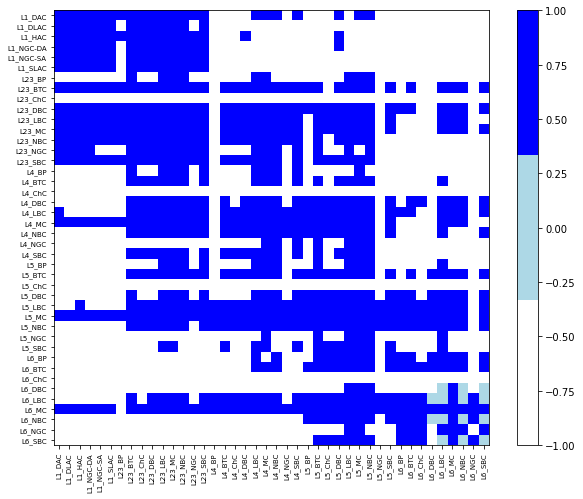

In [443]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = ListedColormap(["white", "lightblue", "blue"])

fontsiz=18
figSize = (10,8)
fig = plt.figure(figsize=figSize)  # Open a new figure    

# ------------------------------------------------------------------------------ #
plt.subplot(1, 1, 1)
number = 0
matrix = np.zeros((42, 42)) #13 + 42
for pre in Ipops:
    number2 = 0
    for post in Ipops:
        if float(connNumber[pre][post]) > 0:
            matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][0]]
        else:
            matrix[number][number2] = -1   
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(42), Ipops, fontsize=7, rotation=90);
plt.yticks(range(42), Ipops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
# plt.clim(0,11)
plt.colorbar()

plt.savefig('II.png', facecolor = 'white' , dpi=300)

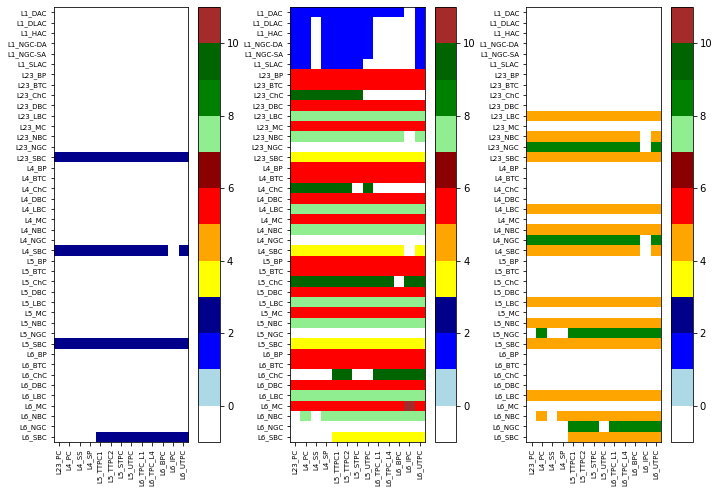

In [444]:
fontsiz=18
figSize = (12,8)
fig = plt.figure(figsize=figSize)  # Open a new figure    

cmap = ListedColormap(["white", "lightblue", "blue", "lightblue", "blue", "darkblue", "blue", "blue", "blue", "darkblue", "blue", "blue"])
cmap = ListedColormap(["white", "lightblue", "blue", "darkblue", "yellow", "orange", "red", "darkred", "lightgreen", "green", "darkgreen", "brown"])

# ------------------------------------------------------------------------------ #
plt.subplot(1, 3, 1)
number = 0
matrix = np.zeros((42, 13)) #13 + 42
for pre in Ipops:
    number2 = 0
    for post in Epops:   
        matrix[number][number2] = -1        
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '1' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]] 
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(13), Epops, fontsize=7, rotation=90);
plt.yticks(range(42), Ipops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(-1,11)
plt.colorbar()
# ------------------------------------------------------------------------------ #

plt.subplot(1, 3, 2)
number = 0
matrix = np.zeros((42, 13)) #13 + 42
for pre in Ipops:
    number2 = 0
    for post in Epops:
        matrix[number][number2] = -1   
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '2' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]]
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(13), Epops, fontsize=7, rotation=90);
plt.yticks(range(42), Ipops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(-1,11)
plt.colorbar()
# ------------------------------------------------------------------------------ #
plt.subplot(1, 3, 3)
number = 0
matrix = np.zeros((42, 13)) #13 + 42
for pre in Ipops:
    number2 = 0
    for post in Epops:
        matrix[number][number2] = -1   
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '3' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]]
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(13), Epops, fontsize=7, rotation=90);
plt.yticks(range(42), Ipops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(-1,11)
plt.colorbar()


plt.savefig('IE.png', facecolor = 'white' , dpi=300)

In [445]:
matrix

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4., -1.,  4.],
       [ 8.,  8.,  8.,  8.,  8.,  8., 

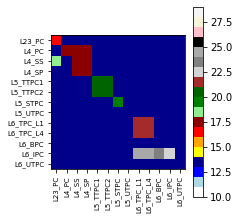

In [446]:

cmap = ListedColormap(["white", "lightblue", "blue", "darkblue", "yellow", "orange", "red", "darkred", "lightgreen", "green", "darkgreen", "brown",
                       "lightgray","gray","darkgray","black","pink","beige","whitesmoke"])

# cmap = ListedColormap(["white", "lightblue", "blue", "darkblue", "yellow"])

fontsiz=18
figSize = (3,3.5)
fig = plt.figure(figsize=figSize)  # Open a new figure    

# ------------------------------------------------------------------------------ #
plt.subplot(1, 1, 1)
number = 0
matrix = np.zeros((13, 13)) #13 + 42
for pre in Epops:
    number2 = 0
    for post in Epops:
        if float(connNumber[pre][post]) > 0:
            matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][0]]
        else:
            matrix[number][number2] = -1   
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(13), Epops, fontsize=7, rotation=90);
plt.yticks(range(13), Epops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(10,28.99)
# plt.clim(10,14)
plt.colorbar()

plt.savefig('EE.png', facecolor = 'white' , dpi=300)


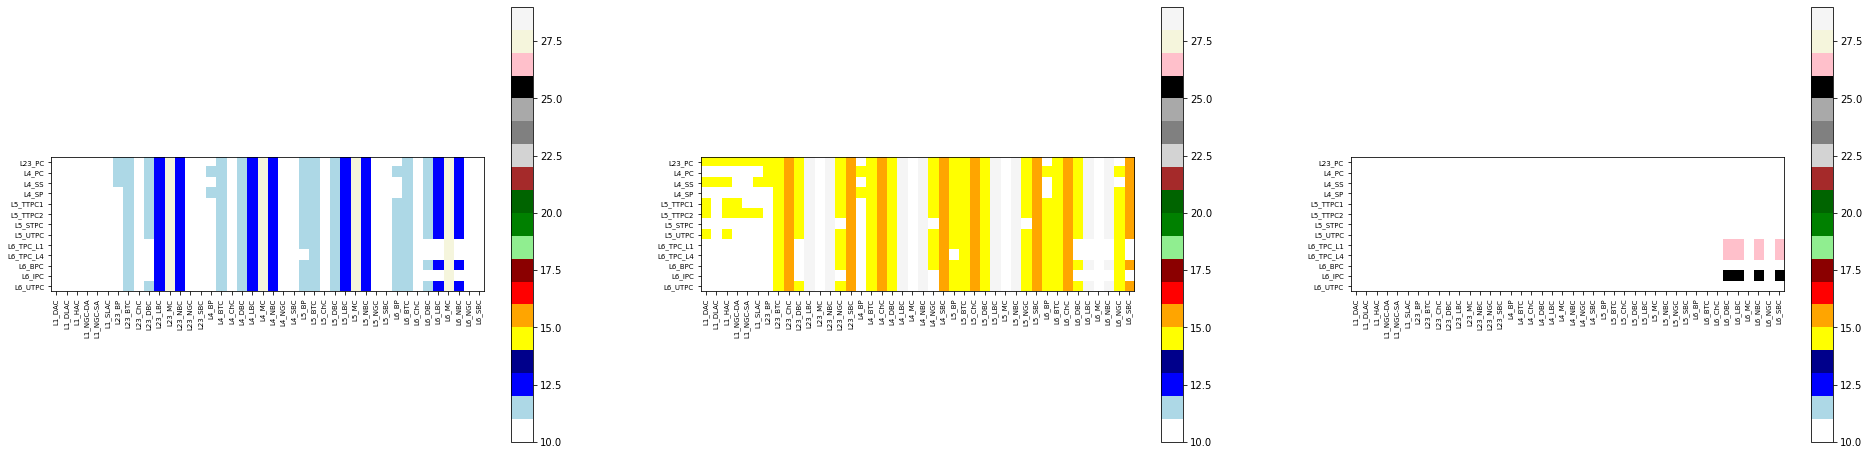

In [447]:
cmap = ListedColormap(["white", "lightblue", "blue", "darkblue", "yellow", "orange", "red", "darkred", "lightgreen", "green", "darkgreen", "brown",
                       "lightgray","gray","darkgray","black","pink","beige","whitesmoke"])

fontsiz=18
figSize = (33,8)
fig = plt.figure(figsize=figSize)  # Open a new figure    

# ------------------------------------------------------------------------------ #
plt.subplot(1, 3, 1)
number = 0
matrix = np.zeros((13, 42)) #13 + 42
for pre in Epops:
    number2 = 0
    for post in Ipops:
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '1' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]] 
        else:
            matrix[number][number2] = -1   
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(42), Ipops, fontsize=7, rotation=90);
plt.yticks(range(13), Epops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(10,28.99)
plt.colorbar()

# ------------------------------------------------------------------------------ #
plt.subplot(1, 3, 2)
number = 0
matrix = np.zeros((13, 42)) #13 + 42
for pre in Epops:
    number2 = 0
    for post in Ipops:
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '2' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]] 
        else:
            matrix[number][number2] = -1   
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(42), Ipops, fontsize=7, rotation=90);
plt.yticks(range(13), Epops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(10,28.99)
plt.colorbar()

# ------------------------------------------------------------------------------ #
plt.subplot(1, 3, 3)
number = 0
matrix = np.zeros((13, 42)) #13 + 42
for pre in Epops:
    number2 = 0
    for post in Ipops:
        if float(connNumber[pre][post]) > 0:
            for stype in range(ConnTypesNumber[pre][post]):
                if '3' in dfS6['s-types'][ConnTypes[pre][post][stype]]:
                    matrix[number][number2] = dfS6['ConnType'][ConnTypes[pre][post][stype]] 
        else:
            matrix[number][number2] = -1   
        number2 = number2 + 1   
    number = number + 1
    
# np.savetxt('matrix_gsyn.txt',matrix, fmt='%.2f', delimiter=" ")
plt.xticks(range(42), Ipops, fontsize=7, rotation=90);
plt.yticks(range(13), Epops, fontsize=7, rotation=0);

plt.imshow(matrix, cmap=cmap)
plt.clim(10,28.99)
plt.colorbar()

plt.savefig('EI.png', facecolor = 'white' , dpi=300)


In [448]:
x = list(dfS6['ConnType'])
y = list(dfS6['gsyn'])
e = list(dfS6['gsynStd'])

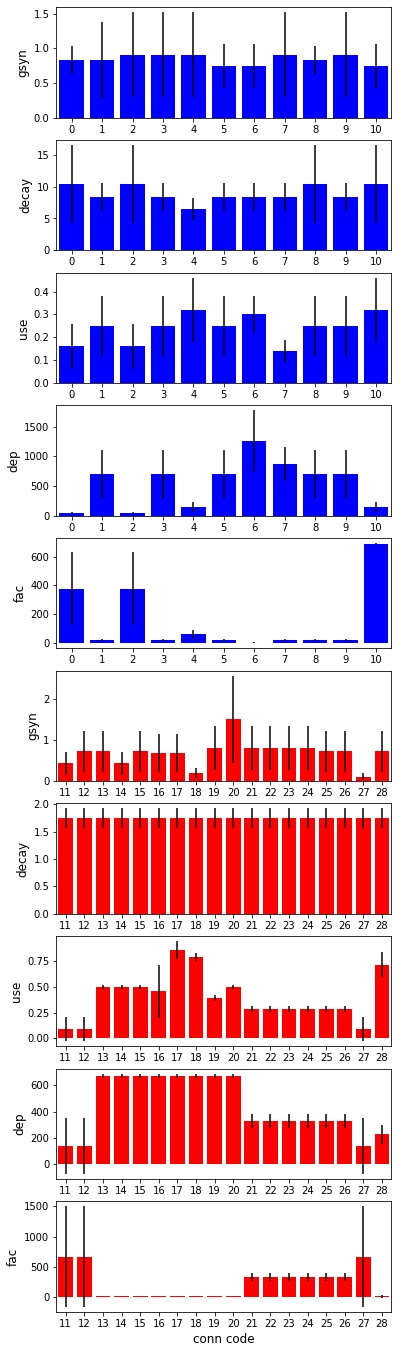

In [450]:
plt.figure(figsize=(6,24))
x = list(dfS6['ConnType'])
number = 0
for keys in ['gsyn', 'decay', 'use', 'dep', 'fac']:
    number+= 1
    plt.subplot(10, 1, number)
    y = list(dfS6[keys])
    e = list(dfS6[keys+'Std'])
    plt.bar(x[0:11], y[0:11], yerr=e[0:11], color='blue')
    plt.ylabel(keys, fontsize=12)
    plt.xlim(-0.5,10.5)
    plt.xticks(x[0:11], fontsize=10);
    plt.yticks(fontsize=10);
  
for keys in ['gsyn', 'decay', 'use', 'dep', 'fac']:
    number+= 1
    plt.subplot(10, 1, number)
    y = list(dfS6[keys])
    e = list(dfS6[keys+'Std'])
    plt.bar(x[11:29], y[11:29], yerr=e[11:29], color='red')
    plt.ylabel(keys, fontsize=12)
    plt.xlim(10.5,28.5)
    plt.xticks(x[11:29], fontsize=10);
    plt.yticks(fontsize=10);
    
plt.xlabel('conn code', fontsize=12)
plt.savefig('synPhys.png', facecolor = 'white' , dpi=300)